# Portfolio Optimization: Risk and Return Model Simulations

In this notebook, we will perform portfolio optimization using historical data of selected stocks. The objective is to maximize the Sharpe Ratio, which indicates the best risk-adjusted return of a portfolio.

## Importing Required Libraries


In [8]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import yfinance as yf


## Data Retrieval

We will retrieve historical stock data for selected tickers using Yahoo Finance. Replace 'FB' with 'META' or any other ticker as per your requirement.


In [9]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META']  # Updated tickers
data = yf.download(tickers, start="2020-01-01", end="2023-01-01")['Adj Close']


[*********************100%%**********************]  5 of 5 completed


## Data Preprocessing

Calculating daily returns and preparing the data for analysis.


In [10]:
# Calculate daily returns
returns = data.pct_change().dropna()

# Recalculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()


## Portfolio Optimization Setup

Setting the parameters for the portfolio optimization, including the number of portfolios to simulate and the risk-free rate.


In [11]:
# Number of portfolios to simulate
num_portfolios = 10000

# Risk-free rate (approximation)
risk_free_rate = 0.02


## Defining Performance Metrics

Functions to calculate portfolio performance and the negative Sharpe Ratio for optimization.


In [12]:
def portfolio_performance(weights):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def neg_sharpe_ratio(weights):
    p_std, p_ret = portfolio_performance(weights)
    return -(p_ret - risk_free_rate) / p_std


## Running the Optimization

Optimizing the portfolio to find the best weights that maximize the Sharpe Ratio.


In [13]:
# Constraints and Bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in mean_returns)
initial_guess = [1. / len(mean_returns) for _ in mean_returns]

# Optimize portfolio
optimal_portfolio = minimize(neg_sharpe_ratio, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights and portfolio performance
optimal_weights = optimal_portfolio.x
portfolio_std_dev, portfolio_return = portfolio_performance(optimal_weights)

# Displaying optimized portfolio weights, expected return, and risk
print("\nOptimized Portfolio Weights:")
for ticker, weight in zip(returns.columns, optimal_weights):
    print(f"{ticker}: {weight:.2%}")

print(f"\nExpected Annualized Portfolio Return: {portfolio_return:.2%}")
print(f"Annualized Portfolio Standard Deviation: {portfolio_std_dev:.2%}")



Optimized Portfolio Weights:
AAPL: 97.28%
AMZN: 0.00%
GOOG: 0.00%
META: 0.00%
MSFT: 2.72%

Expected Annualized Portfolio Return: 25.65%
Annualized Portfolio Standard Deviation: 36.70%


## Visualizing the Efficient Frontier

Plotting the Efficient Frontier to show the trade-off between risk and return for different portfolio compositions.


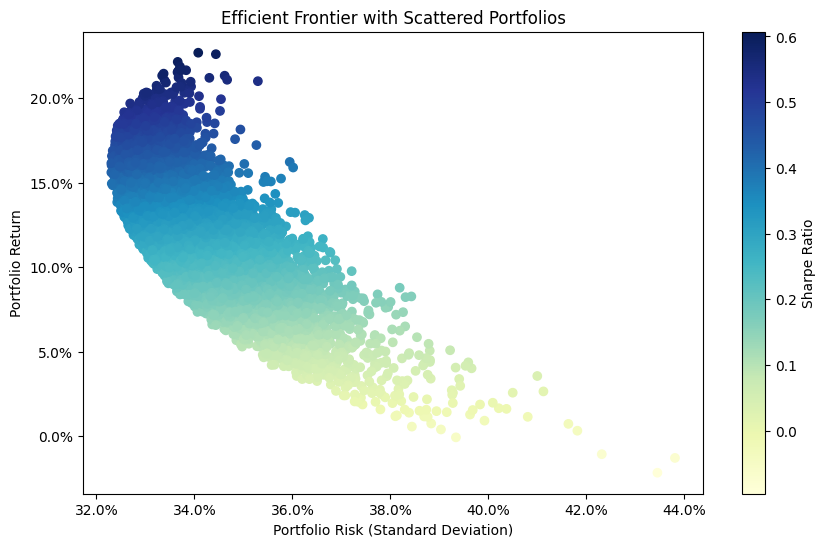

In [14]:
def efficient_frontier(num_portfolios):
    results = np.zeros((3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_std_dev, portfolio_return = portfolio_performance(weights)
        results[0, i] = portfolio_std_dev
        results[1, i] = portfolio_return
        results[2, i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results

results = efficient_frontier(num_portfolios)

plt.figure(figsize=(10, 6))
plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier with Scattered Portfolios')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.colorbar(label='Sharpe Ratio')
plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1))
plt.show()
